# Air Temperature Forecasting

## Import Necessary Libraries

In [1]:
## Import necessary libraries
import pandas as pd
import numpy as np
import random 
from urllib.parse import quote, unquote
from datetime import timedelta
import matplotlib.pyplot as plt

## Import libraries for the model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import trange
from sklearn.metrics import mean_squared_error, r2_score

## Set path for saving model training results
import os
os.makedirs('./result', exist_ok=True)

## Set Cuda for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Set random seed
def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

# Set seed
seed_val = 77
set_seed(seed_val)

cuda


## Selecting Data Columns
* Tag names are loaded in sequential order.
* The process of selecting the required tag names from the tag name list.

In [2]:
# Function to display tag names
def show_column(URL):
    
    # Load tag name data
    df = pd.read_csv(URL)
    
    # Convert to list format
    df = df.values.reshape(-1)
    
    return df.tolist()

In [3]:
## Set parameters for displaying tag names
table = 'san_diego_weather'

NAME_URL = f'http://127.0.0.1:5654/db/tql/datahub/api/v1/get-tag-names.tql?table={table}'

## Generate tag name list
name = show_column(NAME_URL)

In [4]:
name

['air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'min_wind_direction',
 'min_wind_speed',
 'rain_accumulation',
 'rain_duration',
 'relative_humidity']

## Converting TAG Name Format
* After checking all the Tag Names from the San Deigo Daily Weather dataset in the previous step, extract only the columns to be used and convert them into parameter format.
* Use air_temp tag name.

In [5]:
# Set the desired tag names
tags = ['air_temp']

# Wrap each item in the list with single quotes and separate with commas
tags_ = ",".join(f"'{tag}'" for tag in tags)

# Check the selected tag names
print(tags_)

'air_temp'


## Load San Deigo Daily Weather dataset
* Load the data using tag names

In [6]:
# Data loading function
def data_load(table, name, start_time, end_time, timeformat):
    
    # Load data 
    df = pd.read_csv(f'http://127.0.0.1:5654/db/tql/datahub/api/v1/select-rawdata.tql?table={table}&name={name}&start={start_time}&end={end_time}&timeformat={timeformat}')

    # Convert to data grouped by the time
    df = df.pivot_table(index='TIME', columns='NAME', values='VALUE', aggfunc='first').reset_index()

    # Set TIME column
    df['TIME'] = pd.to_datetime(df['TIME'])
    
    # Set time index
    df.set_index('TIME', inplace=True)
    
    # Move 'value' column to the end
    df['air_temp'] = df.pop('air_temp')

    # Resample data at 1-hour intervals
    df = df.resample('1H').mean()
    
    return df

In [ ]:
# Data time loading function
def time_data_load(table, name, start_time, end_time, timeformat):
    
    target = 'TIME'
    
    # Load the data
    df = pd.read_csv(f"http://127.0.0.1:5654/db/tql/datahub/api/v1/select-rawdata.tql?target={target}&table={table}&name={name}&start={start_time}&end={end_time}&timeformat={timeformat}")
    
    # Create a dummy value column for resampling
    df['value'] = 0
    
    # Perform resampling
    df['TIME'] = pd.to_datetime(df['TIME'])
    df.set_index('TIME', inplace=True)
    # Determine resampling units based on the data and perform resampling
    df = df.resample('1H').mean()
    
    # Remove missing values
    df = df.dropna()
    
    # Remove the dummy value column
    df = df.drop(['value'], axis=1)
    
    return df

In [8]:
# Time update function
# Update start and end times based on batch size
def update_time(time_df, start_time, batch_size, window_size, forecast_size):
    
    # Calculate how many data points need to be loaded
    time = batch_size + window_size + forecast_size - 2
    
    # Check the index number of the current time
    # If not found, set to the first index as there is no data for the current time
    try:
        index_now = time_df.index.get_loc(start_time)
    except KeyError:
        index_now = 0
    
    # Set the end time for the batch data based on the current time 
    end_time_ = str(time_df.index[index_now + time] + timedelta(seconds=1))
    
    # Set the index number for the next start time
    index_next = index_now + time + 1
    
    # Set the next start time
    next_start_time_ = str(time_df.index[index_next])
    
    # URL encoding
    start_time_ = quote(start_time)
    end_time_ = quote(end_time_)
    next_start_time_ = quote(next_start_time_)
    
    return start_time_, end_time_, next_start_time_, index_next

In [9]:
# Sliding Window Dataset Configuration
def time_slide_df(df, window_size, forecast_size):
    df_ = df.copy()
    data_list = []
    dap_list = []
    for idx in range(0, df_.shape[0]-window_size-forecast_size+1):
        x = df_.iloc[idx:idx+window_size].values.reshape(window_size, df.shape[1])
        y = df_.iloc[idx+window_size:idx+window_size+forecast_size].values
        data_list.append(x)
        dap_list.append(y)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32')

In [10]:
# Function to calculate the maximum and minimum values for selected tag names
def set_minmax_value(table, name, start_time_train, end_time_train):
    
    # URL encoding
    start = quote(start_time_train)
    end = quote(end_time_train)
    
    # Load Min, Max data
    df_ = pd.read_csv(f'http://127.0.0.1:5654/db/tql/datahub/api/v1/select-scale.tql?table={table}&name={name}&start={start}&end={end}')
    
    # Set Min, Max values
    Min = df_.iloc[:,1:-1].T
    Max = df_.iloc[:,2:].T
    
    return Min, Max 

## Data Preprocessing

* 1 MinMax Scaling

### 1. Min-Max Scaling Setup
* Set up a Min-Max Scaler that uses the maximum and minimum values, as the entire dataset is not loaded due to the process concept.

In [11]:
# Definition of the MinMaxScaler class
class MinMaxScaler_custom:
    def __init__(self):
        self.min_ = None
        self.max_ = None

    # Set scale values based on the specified parameters
    def transform(self, X, min_values, max_values):
        X = np.array(X)
        self.min_ = np.array(min_values)
        self.max_ = np.array(max_values)
        
        if self.min_ is None or self.max_ is None:
            raise ValueError("Min and Max values are not set.")
        
        scale = (self.max_ - self.min_)
        if np.any(scale == 0):
            raise ValueError("Min and Max values are the same, resulting in a scale of 0.")
        
        return (X - self.min_) / scale
    
    # Normalize data based on calculated scale values
    def fit_transform(self, X, min_values, max_values):
        """Set parameters and then transform X"""
        return self.transform(X, min_values, max_values)

    # Inverse the normalized data back to original values
    def inverse_transform(self, X_scaled):
        """Inverse the transformation and return original values"""
        if self.min_ is None or self.max_ is None:
            raise ValueError("Min and Max values are not set.")
        
        X_scaled = np.array(X_scaled)
        scale = (self.max_ - self.min_)
        
        return X_scaled * scale + self.min_

## Model Configuration
* Using DLinear model.

In [12]:
## modeling
class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - 0.3*moving_mean
        return moving_mean, residual 
        
class LTSF_DLinear(torch.nn.Module):
    def __init__(self, window_size, forecast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forecast_size = forecast_size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size

        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forecast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forecast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forecast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forecast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forecast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forecast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size,  self.forecast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forecast_size, self.window_size]))

    def forward(self, x):
        trend_init, seasonal_init = self.decompsition(x)
        trend_init, seasonal_init = trend_init.permute(0,2,1), seasonal_init.permute(0,2,1)
        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forecast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forecast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:, idx, :])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])                
        else:

            trend_output = self.Linear_Trend(trend_init)

            seasonal_output = self.Linear_Seasonal(seasonal_init)
            
        x = seasonal_output + trend_output
        return x.permute(0,2,1)

In [13]:
# Model configuration parameters

# Learning rate
lr = 0.001

# Window size: How many past data points will be used
# Forecast: How many future data points to forcast
window_size= 10
forecast_size= 5

# Model configuration
model = LTSF_DLinear(
                    window_size=window_size,
                    forecast_size=forecast_size,
                    kernel_size=25,
                    individual=False,
                    feature_size=1
                    ).to(device)

# Configure loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Check the model architecture
print(model)

LTSF_DLinear(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Trend): Linear(in_features=10, out_features=5, bias=True)
  (Linear_Seasonal): Linear(in_features=10, out_features=5, bias=True)
)


## Model Training

In [14]:
# Model training function
def train(table, name, timeformat, model, batch_size, epochs, scaler, Min, Max, time_df_train, window_size, forecast_size):
    
    # Initialize training loss
    train_loss = []

    # Initialize best loss value
    best_Loss = np.inf

    for epoch in epochs:
        
        # Set the model to training mode
        model.train()
        
        # Initialize loss and total step
        running_loss = 0.0
        total_step = 0
        
        # Set initial start time
        start_time_ = str(time_df_train.index[0])
        
        # Set end time
        end_time_train = str(time_df_train.index[-1])
        
        # Use a while loop to call data 
        while start_time_ < end_time_train:
            
            # Set the time for loading data based on the batch size
            start_time_, end_time_, next_start_time_, index_next = update_time(time_df_train, start_time_, batch_size, window_size, forecast_size)
        
            # Load batch data
            data = data_load(table, name, start_time_, end_time_, timeformat)

            # Apply MinMax scaler
            data_scaled = scaler.fit_transform(data, Min, Max)
            
            # Set up the DataFrame
            data = pd.DataFrame(data_scaled)
            
            # Set window & target
            train_x, train_y = time_slide_df(data, window_size, forecast_size)
            
            # Print if the loaded data is empty
            if len(train_x) == 0:
                print("No data available.")
            
            # Input the data into the model when it accumulates to the batch size
            if len(train_x) == batch_size:
                
                # Check total batch count
                total_step += 1
                
                # Convert data to numpy arrays
                input_data = np.array(train_x)
                input_target = np.array(train_y)
                
                # Convert data to Tensor
                input_data = torch.tensor(input_data, dtype=torch.float32).to(device).float()
                input_target = torch.tensor(input_target, dtype=torch.float32).to(device).float()
                
                # Optimize the optimizer
                optimizer.zero_grad()    
                
                # Input to the model
                outputs = model(input_data)         
            
                # Calculate loss
                loss = criterion(outputs, input_target)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                
                # Reset batch data
                data = []                    
                
            # Set the next start time
            start_time_ = unquote(next_start_time_)
            
            # Prevent fetching beyond the last time
            if index_next + batch_size + window_size + forecast_size >= len(time_df_train):
                break
            
        # Print training loss
        train_loss.append(running_loss / total_step)
        print(f'\ntrain loss: {np.mean(train_loss)}')
        
        # Save the model if it has the best loss
        if best_Loss > np.mean(train_loss):
            best_Loss = np.mean(train_loss)
            torch.save(model, f'./result/San_Diego_Daily_Weather_New_Batch.pt')
            print('Model saved')
        epochs.set_postfix_str(f"epoch = {epoch}, best_Loss = {best_Loss}")
        
    return model   

In [15]:
########################################### Training Parameter Settings ################################################
# Set the tag table name
table = 'san_diego_weather'
# Set the tag names
name = quote(tags_, safe=":/")
# Set the time format 
timeformat = 'default'
# Set the data start time
start_time_train = '2011-09-10 00:00:00'
# Set the data end time
end_time_train = '2014-08-31 23:59:00'
# Set batch size
batch_size = 64
# Set number of epochs
epochs = trange(100, desc='training')
# Set Min, Max value 
Min, Max = set_minmax_value(table, name, start_time_train, end_time_train)
# Set scalers
scaler = MinMaxScaler_custom()
# Load training time list 
time_df_train = time_data_load(table, name, quote(start_time_train), quote(end_time_train), timeformat)
########################################### Proceed with training ################################################
train(table, name, timeformat, model, batch_size, epochs, scaler, Min, Max, time_df_train, window_size, forecast_size)

training:   0%|          | 0/100 [00:00<?, ?it/s]


train loss: 0.011485243392065216
Model saved

train loss: 0.007854245666596704
Model saved

train loss: 0.0064088216248658104
Model saved

train loss: 0.005605952781195016
Model saved

train loss: 0.005079182242645435
Model saved

train loss: 0.004699095854419342
Model saved

train loss: 0.004409059584923395
Model saved

train loss: 0.004179555105861118
Model saved

train loss: 0.003993142625568276
Model saved

train loss: 0.0038386265394860773
Model saved

train loss: 0.0037084124719780408
Model saved

train loss: 0.003597142428673182
Model saved

train loss: 0.0035009207727557438
Model saved

train loss: 0.0034168470781604705
Model saved

train loss: 0.0033427187133367653
Model saved

train loss: 0.0032768348797511167
Model saved

train loss: 0.003217863745966987
Model saved

train loss: 0.003164748677241219
Model saved

train loss: 0.003116640411953014
Model saved

train loss: 0.0030728480434085823
Model saved

train loss: 0.0030328034546616258
Model saved

train loss: 0.0029960351

LTSF_DLinear(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Trend): Linear(in_features=10, out_features=5, bias=True)
  (Linear_Seasonal): Linear(in_features=10, out_features=5, bias=True)
)

## Model Testing

In [16]:
def test(table, name, timeformat, model, batch_size, scaler, Min, Max, time_df_test, window_size, forecast_size):
    with torch.no_grad():
                
        model.eval()
        
        # Initial settings 
        output_test = []
        output_target = []
            
        # Set the initial start time
        start_time_t = str(time_df_test.index[0])
        
        # Set the end time
        end_time_test = str(time_df_test.index[-1])
        
        # Use a while loop to call data 
        while start_time_t < end_time_test:
            
            # Set the time for loading data based on the batch size
            start_time_t, end_time_t, next_start_time_t, index_next_t = update_time(time_df_test, start_time_t, batch_size, window_size, forecast_size)
        
            # Load batch data
            data_t = data_load(table, name, start_time_t, end_time_t, timeformat)

            # Apply MinMax scaler
            data_scaled = scaler.fit_transform(data_t, Min, Max)
            
            # Set up the DataFrame
            data_t = pd.DataFrame(data_scaled)
            
            # Set window & target
            test_x, test_y = time_slide_df(data_t, window_size, forecast_size)
            
            # Print if the loaded data is empty
            if len(test_x) == 0:
                print("No data available.")
            
            # Input the data into the model when it accumulates to the batch size
            if len(test_x) == batch_size:
                
                # Convert data to numpy arrays
                input_data_t = np.array(test_x)
                input_target_t = np.array(test_y)
                
                # Convert data to Tensor
                input_data_t = torch.tensor(input_data_t, dtype=torch.float32).to(device).float()
                input_target_t = torch.tensor(input_target_t, dtype=torch.float32).to(device).float()
                
                # Model input
                outputs_t = model(input_data_t)
                
                output_test.append(outputs_t)
                output_target.append(input_target_t)
                
                # Reset the batch
                data_t = []
                
            # Set the next start time    
            start_time_t = unquote(next_start_time_t)
            
            # Prevent loading beyond the last time
            if index_next_t + batch_size + window_size + forecast_size >= len(time_df_test):
                break
            
        # Combine tensors into one
        combined_tensor_target = torch.cat(output_target, dim=0)
        combined_tensor_pred = torch.cat(output_test, dim=0)

        # Use only the last value of the window
        last_values_target = combined_tensor_target[:,:1].cpu()
        last_values_pred = combined_tensor_pred[:,:1].cpu()

        # Inverse transform using MinMaxScaler 
        real_values = scaler.inverse_transform(last_values_target.numpy().reshape(-1, 1))
        real_pred_values = scaler.inverse_transform(last_values_pred.numpy().reshape(-1, 1))
        
        return real_values, real_pred_values

In [20]:
########################################### Test Parameter Settings ################################################
# Load the best model
model_ = torch.load(f'./result/San_Diego_Daily_Weather_New_Batch.pt')
# Set the start time for the test data
start_time_test = '2014-09-01 00:00:00'
# Set the end time for the test data
end_time_test = '2014-10-01 00:00:00'
# Load the test time list
time_df_test = time_data_load(table, name, quote(start_time_test), quote(end_time_test), timeformat)

######################################## Proceed with testing #############################################
real_values, real_pred_values = test(table, name, timeformat, model_, batch_size, scaler, Min, Max, time_df_test, window_size, forecast_size)

## Model Performance Evaluation

In [21]:
# Calculate MSE
mse = mean_squared_error(real_values, real_pred_values)
print("Mean Squared Error:", mse)

# Calculate R² Score
r2 = r2_score(real_values, real_pred_values)
print("R² Score:", r2)

Mean Squared Error: 1.9841916527222725
R² Score: 0.9209401573114039


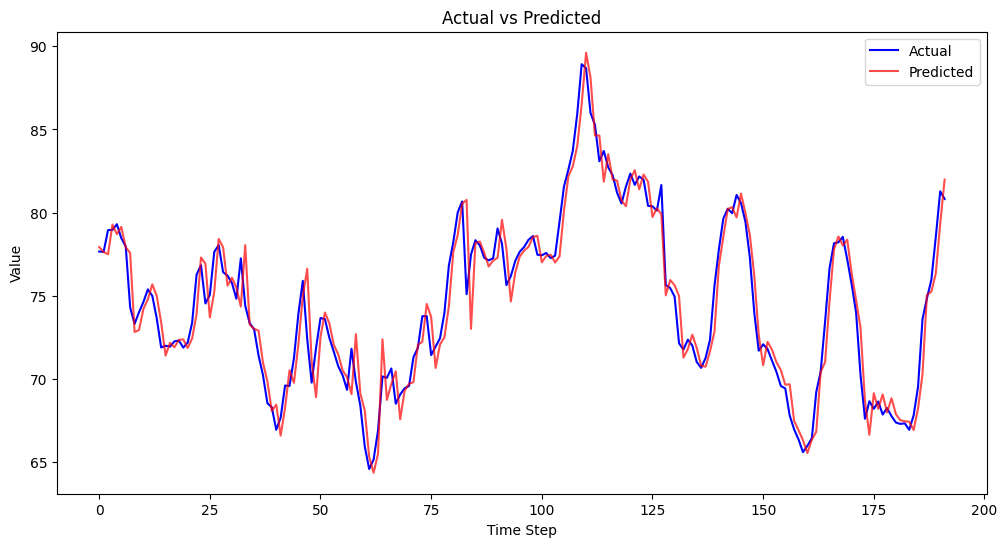

In [22]:
# Compare the test results: Actual values vs Predicted values
plt.figure(figsize=(12, 6))
plt.plot(real_values, label='Actual', color='blue')
plt.plot(real_pred_values, label='Predicted', color='red', alpha=0.7)
plt.title('Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()